In [1]:
import os
import sys

sys.path.insert(0, os.path.abspath('..'))

import plio
from plio.io import io_gdal
import numpy as np
from autocnet import utils
from autocnet.cg import cg as ag
import pandas
import ogr
from autocnet.examples import get_path
from autocnet.graph.network import CandidateGraph
from autocnet.graph import edge
from autocnet.graph import node
from autocnet.vis.graph_view import plot_edge, plot_node
from unittest.mock import Mock
from unittest.mock import MagicMock
from unittest.mock import PropertyMock
from autocnet.matcher.feature import FlannMatcher
from scipy.spatial import Voronoi, voronoi_plot_2d
from autocnet.transformation.transformations import FundamentalMatrix, Homography
import matplotlib.path as mpath
import matplotlib.patches as mpatch
import cv2

from IPython.display import display

%pylab inline
figsize(8, 8)

Populating the interactive namespace from numpy and matplotlib


In [2]:
def scale_poly(point, centroid, scalar):
    point = np.asarray(point)
    centroid = centroid[:2]
    vector = ((point - centroid)*scalar) + centroid
    return (vector)

In [3]:
def compute_vor_weight(vor, voronoi_df, poly_array, intersection_poly, node, verbose):
    i = 0
    for region in vor.regions:
        region_point = vor.points[np.argwhere(vor.point_region==i)]
        if not -1 in region:
            polygon_points = [vor.vertices[i] for i in region]
            if len(polygon_points) != 0:
                polygon = utils.utils.array_to_poly(polygon_points)
                intersection = polygon.Intersection(intersection_poly)
                poly_array = np.append(poly_array, intersection)
                polygon_area = intersection.GetArea()
                voronoi_df.loc[(voronoi_df[node + "_x"] == region_point[0][0][0]) & (voronoi_df[node + "_y"] == region_point[0][0][1]), node + '_weights'] = polygon_area
        i+=1
        
    if (verbose):
        polygons = poly_array
        for i in polygons:
            geom = i.GetGeometryRef(0)
            if geom == None:
                continue
            else:
                points = geom.GetPoints()
                plt.fill(*zip(*points), alpha = .6)

In [4]:
def reproj_point(H, point):
    """
    Reproject a pixel in one image into another image
    
    Parameters
    ----------
    H : object
        (3,3) ndarray or Homography object
        
    corner : iterable
             A 2 element iterable in the form x, y
    """
    if len(point) == 2:
        coords = np.array([point[0],point[1],1])
    elif len(point) == 3:
        coords = np.asarray(point)
        coords *= coords[-1]  # Homogenize
    
    return H.dot(coords)

In [98]:
def voronoi(edge, node, clean_keys=[], k = 30, verbose = False):
    source_corners = edge.source.geodata.xy_corners
    destination_corners = edge.destination.geodata.xy_corners
    
    matches, mask = edge.clean(clean_keys=clean_keys)

    source_indices = pandas.Index(matches['source_idx'].values)
    destination_indices = pandas.Index(matches['destination_idx'].values)
    
    source_keypointsPd = edge.source.get_keypoint_coordinates(index=source_indices)
    destination_keypointsPd = edge.destination.get_keypoint_coordinates(index=destination_indices)
    
    if edge.source.geodata.coordinate_transformation.this != None:
        source_footprint_poly = edge.source.geodata.footprint
        destination_footprint_poly = edge.destination.geodata.footprint

        intersection_poly = destination_footprint_poly.Intersection(source_footprint_poly)
        intersection_geom = intersection_poly.GetGeometryRef(0)
        intersection_points = intersection_geom.GetPoints()

        source_pixel_intersect_points = [edge.source.geodata.latlon_to_pixel(lat, lon) for lat, lon in intersection_points]
        destination_pixel_intersect_points = [edge.destination.geodata.latlon_to_pixel(lat, lon) for lat, lon in intersection_points]
    else:
        
        kp1 = edge.source.get_keypoint_coordinates(index=matches['source_idx'])
        kp2 = edge.destination.get_keypoint_coordinates(index=matches['destination_idx'])
        proj_corners = []

        if node == 'source':
            edge.homography.compute(kp2.values, kp1.values)
            H = edge.homography
            print(H)
            for c in destination_corners:
                x, y, _ = reproj_point(H, c)
                proj_corners.append((x, y))
            
        
            orig_poly = utils.utils.array_to_poly(source_corners)
            proj_poly = utils.utils.array_to_poly(proj_corners)
        
        if node == 'destination':
            edge.homography.compute(kp1.values, kp2.values)
            H = edge.homography
            print(H)
            for c in source_corners:
                x, y, _ = reproj_point(H, c)
                proj_corners.append((x, y))
            
        
            orig_poly = utils.utils.array_to_poly(destination_corners)
            proj_poly = utils.utils.array_to_poly(proj_corners)

        intersection_poly = orig_poly.Intersection(proj_poly)
        intersection_geom = intersection_poly.GetGeometryRef(0)
        intersection_points = intersection_geom.GetPoints()
        
    # Remake voronoi point DF since it was not building correctly
    centroid = intersection_poly.Centroid().GetPoint()
    if verbose & (edge.source.geodata.coordinate_transformation.this == None):
        #Visualize the source image in 'image' space
        fig1 = plt.figure()
        ax1 = fig1.add_subplot(111, aspect='equal')
        if node == 'source':
            ax1.add_patch(Polygon(source_corners, facecolor='blue',alpha=0.25, edgecolor='k'))
            ax1.add_patch(Polygon(proj_corners, facecolor='red', alpha=0.25, edgecolor='k'))
        else:
            ax1.add_patch(Polygon(destination_corners, facecolor='red',alpha=0.25, edgecolor='k'))
            ax1.add_patch(Polygon(proj_corners, facecolor='blue', alpha=0.25, edgecolor='k'))
            
        ax1.set_xlim(-150, 650)
        ax1.set_ylim(-150, 650)
    
    if node == 'source':
        voronoi_df = pandas.DataFrame(data = source_keypointsPd, columns = ["source_x", "source_y", "source_weights"])
        voronoi_df["source_x"] = source_keypointsPd['x']
        voronoi_df["source_y"] = source_keypointsPd['y']
        keypoints = np.asarray(source_keypointsPd)
    
    if node == 'destination':
        voronoi_df = pandas.DataFrame(data = destination_keypointsPd, columns = ["destination_x", "destination_y", "destination_weights"])
        voronoi_df["destination_x"] = destination_keypointsPd['x']
        voronoi_df["destination_y"] = destination_keypointsPd['y']
        keypoints = np.asarray(destination_keypointsPd)

    for i, j in intersection_points:
        new_point = scale_poly((i, j), centroid, k)
        point = np.array([new_point])
        keypoints = np.append(keypoints, point, axis=0)

    vor_polygons = []
    vor = Voronoi(keypoints)
    compute_vor_weight(vor, voronoi_df, vor_polygons, intersection_poly, node, verbose)

    return vor, voronoi_df

In [139]:
#Point to the adjacency Graph
#'two_image_adjacency.json'
#'cube_adjacency.json'
adjacency = get_path('cube_adjacency.json')
basepath = get_path('Apollo15')
cg = CandidateGraph.from_adjacency(adjacency, basepath=basepath)

#Apply SIFT to extract features
cg.extract_features(method='sift', extractor_parameters={'nfeatures':500})

#Match
cg.match_features()

#Apply outlier detection
cg.symmetry_checks()
cg.ratio_checks()

#Compute a homography and apply RANSAC
cg.compute_fundamental_matrices(clean_keys=['ratio', 'symmetry'])

cg.compute_homographies(clean_keys = ['fundamental'])

edge = cg.edge[0][2]

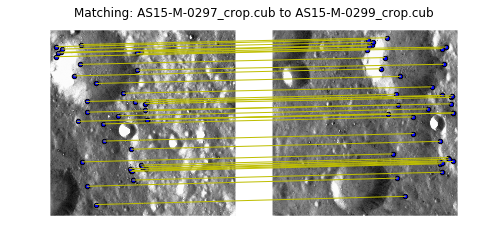

In [140]:
edge.plot(clean_keys = ['fundamental'])

Getting CT
CT <osgeo.osr.CoordinateTransformation; proxy of None >
[[  9.77652518e-01   2.61296702e-03   2.44452350e+02]
 [  2.73572114e-02   9.94355263e-01  -1.95637732e+01]
 [  6.65393657e-05   1.92191407e-06   1.00000000e+00]]


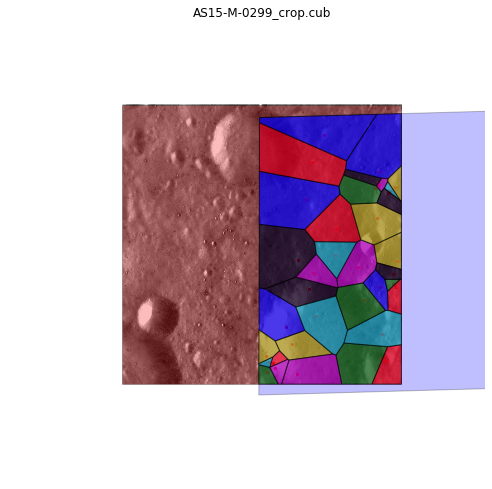

In [141]:
vor = voronoi(edge, 'destination', clean_keys = ['fundamental'], verbose = True, k = 30)
#print(vor[1])

matches, mask = edge.clean(clean_keys = ['fundamental'])

destination_indices = pandas.Index(matches['destination_idx'].values)

points =edge.destination.plot(index_mask = destination_indices)

[[  1.03883730e+00  -2.13155687e-03  -2.53965338e+02]
 [ -2.66264014e-02   1.00248199e+00   2.55027247e+01]
 [ -4.88023414e-05   1.38429501e-05   1.00000000e+00]]


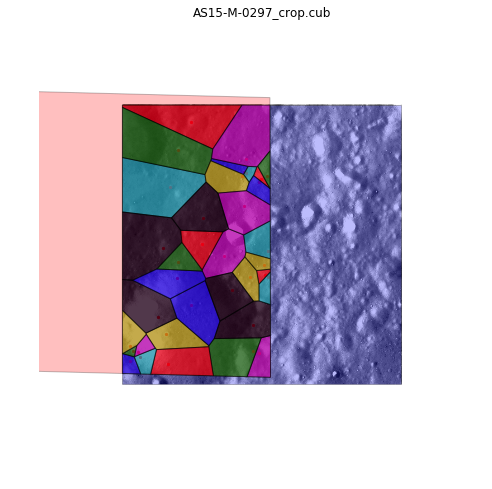

In [142]:
vor = voronoi(edge, 'source', clean_keys = ['fundamental'], verbose = True, k = 30)
#print(vor[1])

matches, mask = edge.clean(clean_keys= ['fundamental'])

source_indices = pandas.Index(matches['source_idx'].values)

edge.source.plot(index_mask = source_indices)

In [10]:
adjacency = get_path('two_image_adjacency.json')
basepath = get_path('Apollo15')
cg = CandidateGraph.from_adjacency(adjacency, basepath=basepath)
keypoint_df = pandas.DataFrame({'x': (15, 18, 18, 12, 12), 'y': (5, 10, 15, 15, 10)})
keypoint_matches = [[0, 0, 1, 0],
                    [0, 1, 1, 1],
                    [0, 2, 1, 2],
                    [0, 3, 1, 3],
                    [0, 4, 1, 4]]

matches_df = pandas.DataFrame(data = keypoint_matches, columns = ['source_image', 'source_idx', 
                                                                  'destination_image', 'destination_idx'])
e = edge

e.clean = MagicMock(return_value=(matches_df, None))

source_node = MagicMock(spec = node.Node())
destination_node = MagicMock(spec = node.Node())

source_node.get_keypoint_coordinates = MagicMock(return_value=keypoint_df)
destination_node.get_keypoint_coordinates = MagicMock(return_value=keypoint_df)

e.source = source_node
e.destination = destination_node

source_geodata = Mock(spec = io_gdal.GeoDataset)
destination_geodata = Mock(spec = io_gdal.GeoDataset)

e.source.geodata = source_geodata
e.destination.geodata = destination_geodata

source_corners = [(0, 0),
                  (20, 0),
                  (20, 20),
                  (0, 20)]

destination_corners = [(10, 5),
                       (30, 5),
                       (30, 25),
                       (10, 25)]

source_xy_extent = [(0, 20), (0, 20)]

destination_xy_extent = [(10, 30), (5, 25)]

source_poly = utils.utils.array_to_poly(source_corners)
destination_poly = utils.utils.array_to_poly(destination_corners)

vals = {(10, 5):(10, 5), (20, 5):(20, 5), (20, 20):(20, 20), (10, 20):(10, 20)}

def latlon_to_pixel(i, j):
    return vals[(i, j)]

e.source.geodata.latlon_to_pixel = MagicMock(side_effect = latlon_to_pixel)
e.destination.geodata.latlon_to_pixel = MagicMock(side_effect = latlon_to_pixel)

e.source.geodata.footprint = source_poly
e.source.geodata.xy_corners = source_corners
e.source.geodata.xy_extent = source_xy_extent
e.destination.geodata.footprint = destination_poly
e.destination.geodata.xy_corners = destination_corners
e.destination.geodata.xy_extent = destination_xy_extent

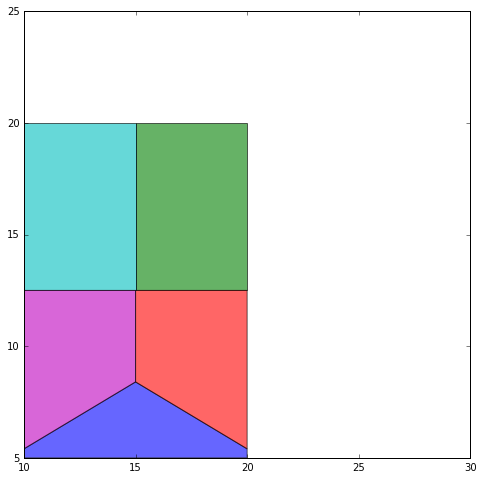

In [11]:
vor = voronoi(e, 'destination', clean_keys=[], verbose = True, k = 3)
destination_extent = e.destination.geodata.xy_extent
plt.xlim(destination_extent[0][0], destination_extent[0][1])
plt.ylim(destination_extent[1][0], destination_extent[1][1])
#voronoi_plot_2d(vor[0])
plt.show()

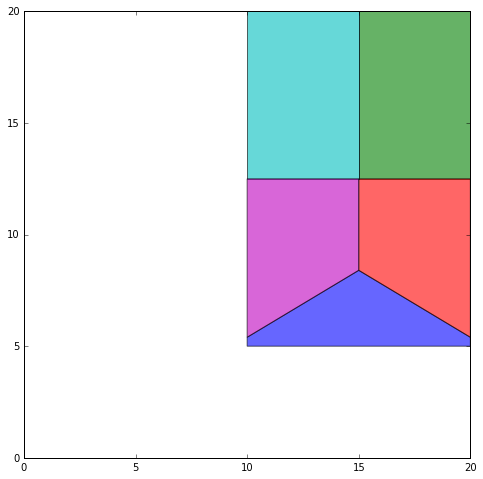

In [12]:
vor = voronoi(e, 'source', clean_keys=[], verbose = True, k = 3)
source_extent = e.source.geodata.xy_extent
plt.xlim(source_extent[0][0], source_extent[0][1])
plt.ylim(source_extent[1][0], source_extent[1][1])
#voronoi_plot_2d(vor[0])
plt.show()